# NTNU Machine Learning Assignment 3

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize
import matplotlib.pyplot as plt

### Load dataset for CIFAR-10 

First we should define a transform for the data from PILLOW Image formats to pytorch tensors and normalize. Unsure what the labels look like, so won't apply a transform right now.

In [2]:
transform = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified


### Understanding the data

Lets get a better idea of what the data looks like. We probably want to understand if the target (labels) need transforming.

In [4]:
training_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

This could be one hot encoded. I'll ammend this now.

In [5]:
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
training_data.target_transform = target_transform

In [6]:
training_data[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [7]:
labels_map = {k: v for k, v in enumerate(training_data.classes)}
labels_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### Visualisation

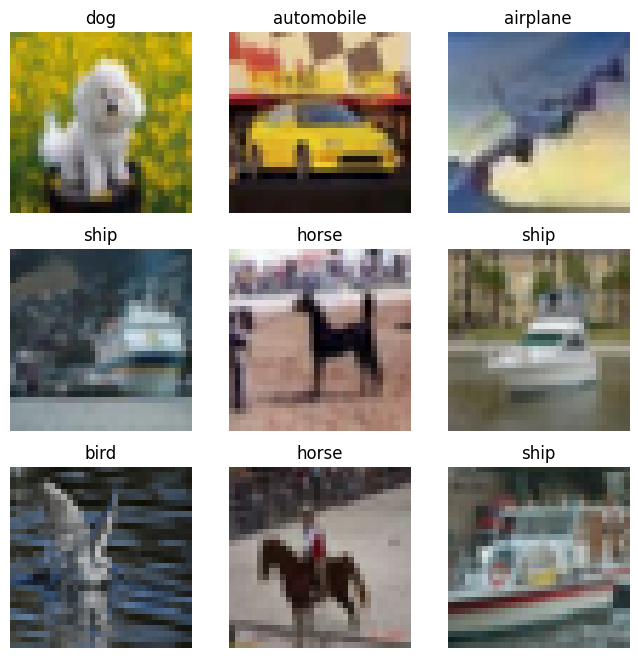

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = img / 2 + 0.5 # Since we normalized above
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[torch.argmax(label, axis=0).item()])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

### Dataloaders to better handle the data in the CNN

In [9]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

Feature batch shape: torch.Size([16, 3, 32, 32])
Labels batch shape: torch.Size([16, 10])


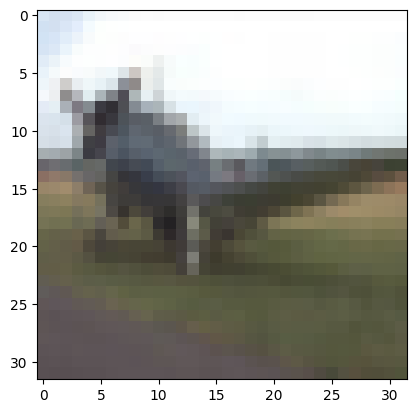

Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img / 2 + 0.5 # Since we normalized above
label = train_labels[0]
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()
print(f"Label: {label}")

### Building the CNN

GPUs are good. If we have one, we might as well use it (assuming Cuda is available).

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Now we can define the CNN Class. Taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [12]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
model = CustomCNN().to(device)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Hyperparameters

In [14]:
learning_rate = 1e-3
momentum = 0.9
epochs = 20

We also need a loss function and optimiser. Since we are creating a classification model, CrossEntropy is probably the best. (If we were doing some regression based, we would use MSE).

We could use SDG or Adam for our optimiser.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=momentum)

### Training and Test Loops

Creating simple functions for training and validation

In [16]:
def train_loop(dataloader, model, loss_fn, optimiser, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)

        optimiser.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimiser.step()
        
        # Print stuff
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.313607  [   16/50000]
loss: 2.290207  [ 1616/50000]
loss: 2.286956  [ 3216/50000]
loss: 2.284943  [ 4816/50000]
loss: 2.296552  [ 6416/50000]
loss: 2.321840  [ 8016/50000]
loss: 2.299083  [ 9616/50000]
loss: 2.300415  [11216/50000]
loss: 2.320856  [12816/50000]
loss: 2.289759  [14416/50000]
loss: 2.265707  [16016/50000]
loss: 2.266023  [17616/50000]
loss: 2.238809  [19216/50000]
loss: 2.136502  [20816/50000]
loss: 2.130318  [22416/50000]
loss: 2.057070  [24016/50000]
loss: 2.074007  [25616/50000]
loss: 2.007866  [27216/50000]
loss: 2.084275  [28816/50000]
loss: 2.178174  [30416/50000]
loss: 1.942877  [32016/50000]
loss: 2.080749  [33616/50000]
loss: 2.075973  [35216/50000]
loss: 2.333631  [36816/50000]
loss: 1.764732  [38416/50000]
loss: 2.262861  [40016/50000]
loss: 2.173055  [41616/50000]
loss: 1.846698  [43216/50000]
loss: 1.879337  [44816/50000]
loss: 1.822355  [46416/50000]
loss: 1.727104  [48016/50000]
loss: 1.658796  [49616/50000]
